# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

## Due: Midnight on October 5th (with 2-hour grace period) and worth 85 points

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **LR schedules**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed / exponential / cosine), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model.

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


## 1. Setup and Data Loading


In [1]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        # print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [3]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 100,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  

In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [5]:
# Reproducible load + preprocess for Intel Image Classification

IMG_SHAPE = (224,224,3)
IMG_SIZE = IMG_SHAPE[:2]

# -------------------------
# Loader (deterministic)
# -------------------------

def load_data_from_directory(directory, img_size=IMG_SIZE, class_names=None, preprocess="mobilenet_v2"):
    """
    Loads images as float32 and integer labels.
    If preprocess == 'mobilenet_v2', outputs are scaled to [-1, 1] as expected by MobileNetV2.
    Else, outputs are scaled to [0,1].
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img).astype("float32")  # values in [0,255]
            if preprocess == "mobilenet_v2":
                # Official Keras preprocessing: scales to [-1, 1]
                arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            else:
                arr = arr / 255.0  # your original behavior
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = np.stack(X).astype("float32")
    y = np.array(y, dtype="int32")
    return X, y, class_names


In [6]:
# Load full training set (preprocessed for MobileNetV2)
X_all, y_all, class_names = load_data_from_directory(
    train_dir, img_size=IMG_SIZE , preprocess="mobilenet_v2"
)

# 80/20 stratified split -> train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=random_seed,
    shuffle=True,
)

# Load test set using same class mapping + preprocessing
X_test, y_test, _ = load_data_from_directory(
    test_dir,
    img_size=IMG_SIZE,
    class_names=class_names
)

num_classes = len(class_names)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

print(f'num_classes: {num_classes}')
print('Class Names:', class_names)

Train: (11227, 224, 224, 3) (11227,)
Val:   (2807, 224, 224, 3) (2807,)
Test:  (3000, 224, 224, 3) (3000,)
num_classes: 6
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Examine The Dataset

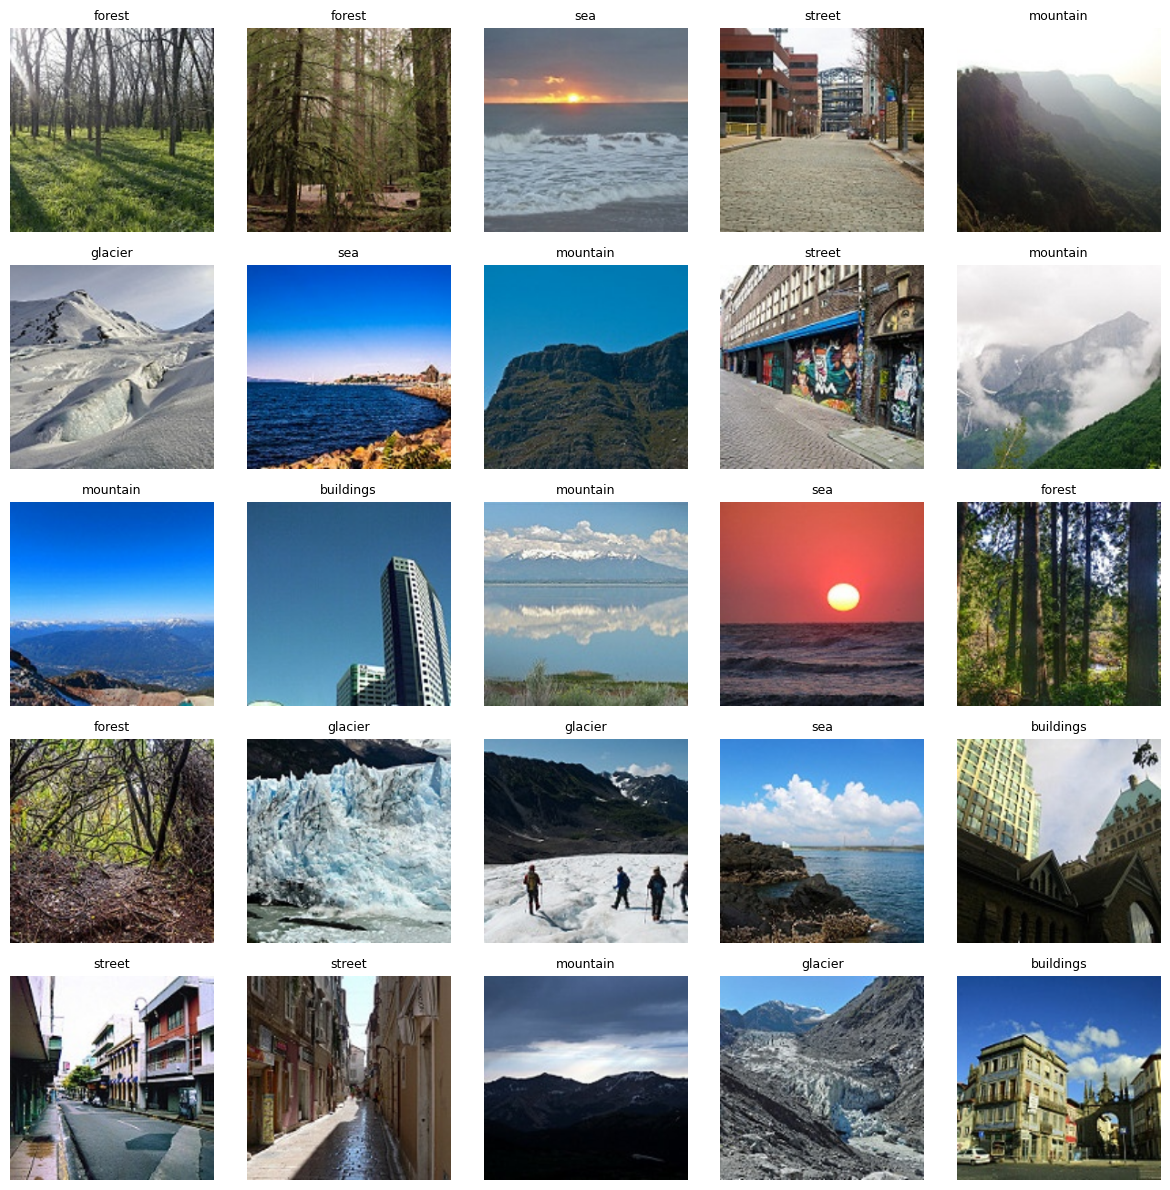

In [7]:
# pick 25 random, distinct indices
idx = np.random.choice(len(X_train), size=25, replace=False)

plt.figure(figsize=(12, 12))
for k, i in enumerate(idx, start=1):
    ax = plt.subplot(5, 5, k)
    ax.imshow((X_train[i] + 1.0) / 2.0)
    # if y_train is one-hot, take argmax; otherwise use the label directly
    label_idx = int(np.argmax(y_train[i])) if getattr(y_train, "ndim", 1) > 1 else int(y_train[i])
    plt.title(class_names[label_idx], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



### Learning Rate Schedulers

In [8]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

In [9]:
# Both these must be input as lr_schedule in train_and_test(....   , lr_schedule=exp_decay, .... )

epochs = 100               # You'll need to adjust this to close to be close to the early stopping location
batch_size = 64

# Needed by LR schedulers

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001,  #  the starting learning rate (before any decay)
    decay_steps=total_steps,     #  how many training steps (batches) before applying decay
    decay_rate=0.98,              #  multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             #  if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #  if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.0001, #  the starting learning rate
    decay_steps=total_steps,      #  number of training steps (batches) over which to decay
    alpha=0.0,                    #  minimum learning rate value as a fraction of initial_learning_rate
                                  #  (final_lr = initial_lr * alpha)
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`.

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).



In [10]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=IMG_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base

base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [11]:
# Ha, this is very long!

base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)


Model Baseline



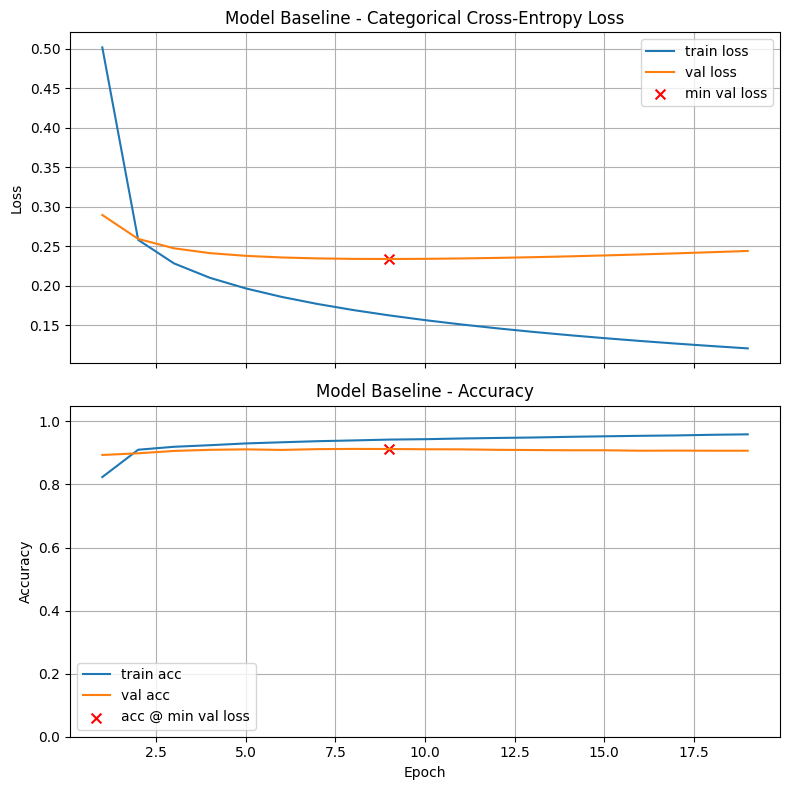

Final Training Loss:            0.1205
Final Training Accuracy:        0.9589
Final Validation Loss:          0.2438
Final Validation Accuracy:      0.9070
Validation Accuracy @ Min Loss: 0.9124

Test Loss: 0.2162
Test Accuracy: 0.9203

Validation-Test Gap (accuracy): 0.007971

Execution Time: 00:03:17


In [12]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()               # default: trainable=False

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')
])

train_and_test(model_baseline, title="Model Baseline")

## Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled()  # default: trainable=False
```


### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads and **give each experiment a unique descriptive title,** i.e., `title="Problem 1 Experiment 1"`
5. **Answer the graded questions.**

### Notes / Constraints

* The descriptive title will be used to compare results at the end of the notebook.
* With `pooling="avg"`, This backbone already applies Global Average Pooling and outputs a **1280-D** feature vector per image. **Do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.


### Problem 1 Experiment 1: Dense Layer with Dropout and Batch Normalization

This experiment uses a single Dense layer with Dropout and Batch Normalization in the head.


Problem 1 Experiment 1: Single Dense Layer with Batch Norm and Dropout



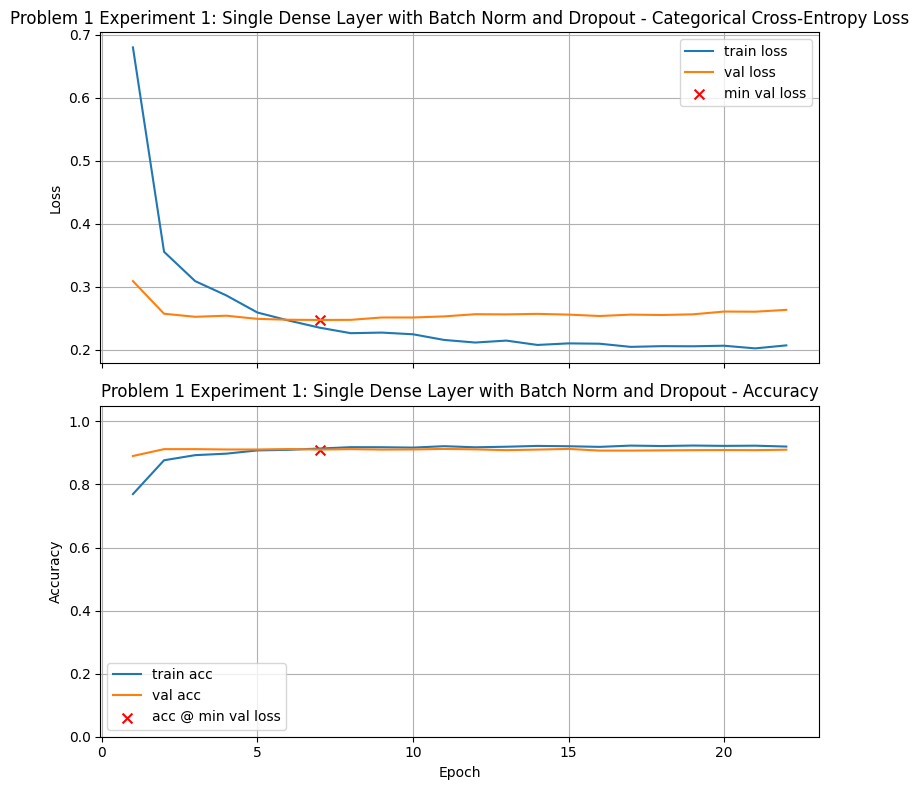

Final Training Loss:            0.2066
Final Training Accuracy:        0.9202
Final Validation Loss:          0.2631
Final Validation Accuracy:      0.9102
Validation Accuracy @ Min Loss: 0.9106

Test Loss: 0.2315
Test Accuracy: 0.9137

Validation-Test Gap (accuracy): 0.003086

Execution Time: 00:02:13


In [13]:
# Experiment 1: Dense Layer with Dropout and Batch Normalization

base_model_exp1 = make_base_model_pooled() # default: trainable=False

model_exp1 = models.Sequential([
    base_model_exp1,
    BatchNormalization(), # BN before Dense can sometimes help
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

train_and_test(model_exp1, title="Problem 1 Experiment 1: Single Dense Layer with Batch Norm and Dropout", epochs=50, patience=15)

### Problem 1 Experiment 2: Multiple Dense Layers with ReLU and Regularization

This experiment uses multiple Dense layers with ReLU activation, L2 regularization, and Dropout.


Problem 1 Experiment 2: Multi Dense Layer with ReLU, L2 Reg, and Batch Norm & Dropout



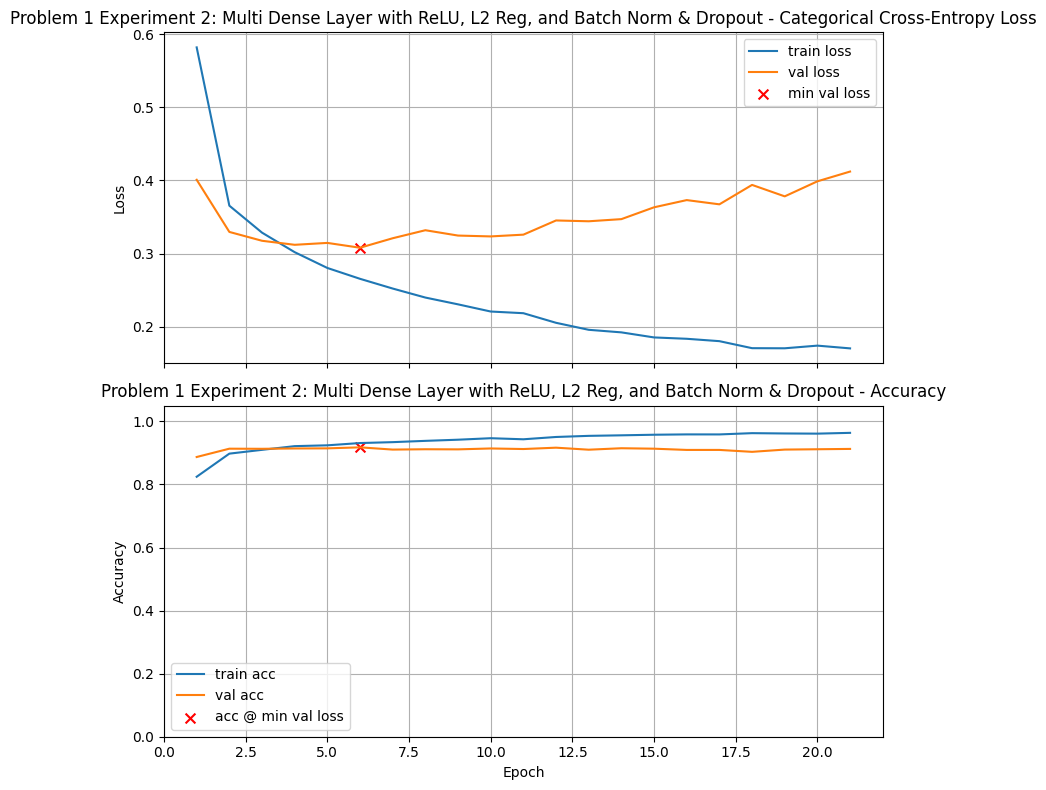

Final Training Loss:            0.1705
Final Training Accuracy:        0.9637
Final Validation Loss:          0.4122
Final Validation Accuracy:      0.9127
Validation Accuracy @ Min Loss: 0.9177

Test Loss: 0.2859
Test Accuracy: 0.9217

Validation-Test Gap (accuracy): 0.003961

Execution Time: 00:02:26


In [14]:
# Experiment 2: Multiple Dense Layers with ReLU and Regularization

base_model_exp2 = make_base_model_pooled() # default: trainable=False

model_exp2 = models.Sequential([
    base_model_exp2,
    Dense(256, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

train_and_test(model_exp2, title="Problem 1 Experiment 2: Multi Dense Layer with ReLU, L2 Reg, and Batch Norm & Dropout", epochs=50, patience=15)

### Problem 1 Experiment 3: Dense Layer with Cosine Decay and ReduceLROnPlateau

This experiment uses a single Dense layer with Cosine Decay and ReduceLROnPlateau.


Problem 1 Experiment 3: Single Dense Layer with Cosine Decay and ReduceLROnPlateau



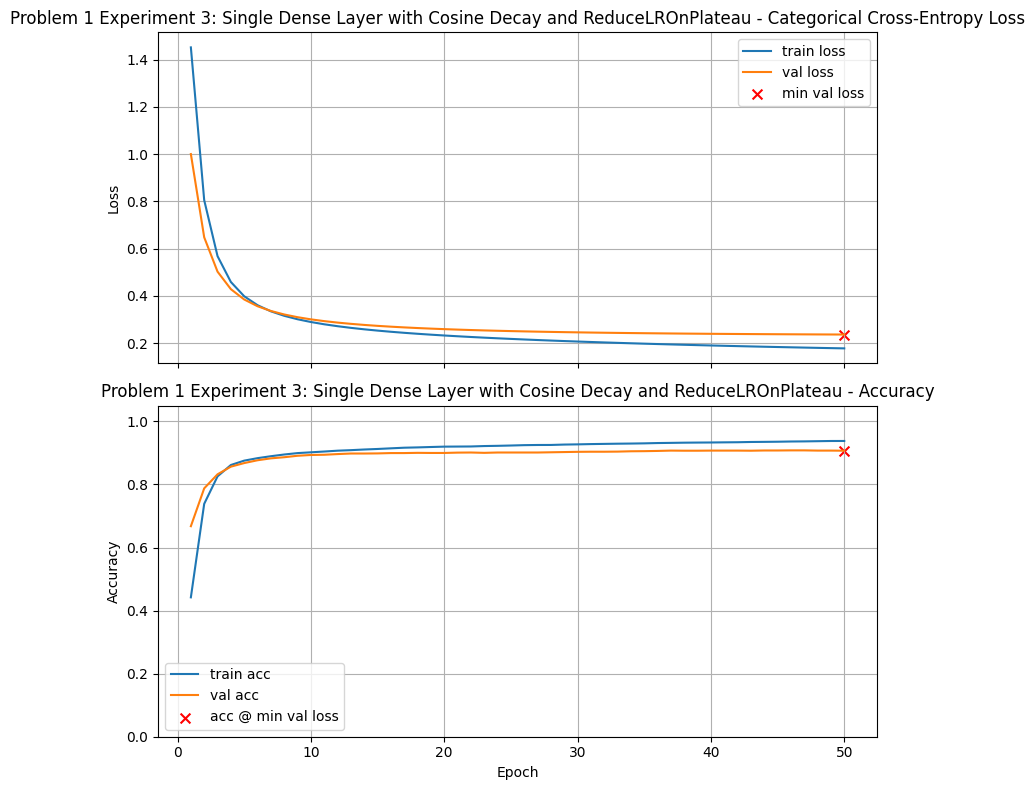

Final Training Loss:            0.1781
Final Training Accuracy:        0.9379
Final Validation Loss:          0.2367
Final Validation Accuracy:      0.9070
Validation Accuracy @ Min Loss: 0.9070

Test Loss: 0.2226
Test Accuracy: 0.9157

Validation-Test Gap (accuracy): 0.008648

Execution Time: 00:03:59


In [15]:
# Experiment 3: Dense Layer with Cosine Decay and ReduceLROnPlateau

base_model_exp3 = make_base_model_pooled() # default: trainable=False

model_exp3 = models.Sequential([
    base_model_exp3,
    Dense(num_classes, activation='softmax')
])

train_and_test(model_exp3, title="Problem 1 Experiment 3: Single Dense Layer with Cosine Decay and ReduceLROnPlateau", epochs=50, patience=15, lr_schedule=cosine_decay, callbacks=[reduce_lr])

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.


**Your answer here:**




Out of the three experiments the second model performed the best. This model was constructed with 3 dense layers of sizes 512, 256, 128. Additionally, the ReLU acitvation function was used along with L2 Regularization, Batch Normalization, and Dropout.  This model most likely performed the best because it allowed the head to learn more complex relationships in the features.

In [22]:
# Set a1 to the validation accuracy found by your best model for this problem.

a1 = .9177             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem

print(f'a1 = {a1}')


a1 = 0.9177


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—don’t add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **unfrozen**. Vary:

   * **Head choice** (pick one from Problem 1).
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**.
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (can combine with a fixed LR).
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 2 Experiment 1"`
3. **Answer the graded questions.**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).

### Problem 2 Experiment 1: Fine-tuning with the best head from Problem 1 and a fixed LR

This experiment uses the best head from Problem 1 and fine-tunes the unfrozen backbone with a fixed learning rate schedule.


Problem 2 Experiment 1: Fine-tune with best head, small fixed LR



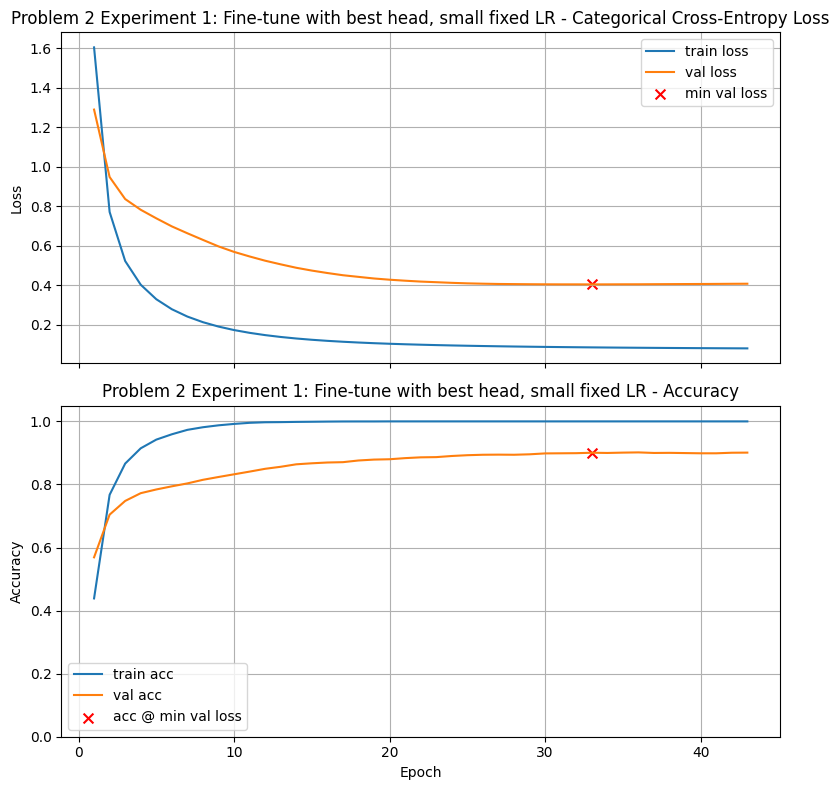

Final Training Loss:            0.0813
Final Training Accuracy:        1.0000
Final Validation Loss:          0.4086
Final Validation Accuracy:      0.9010
Validation Accuracy @ Min Loss: 0.9006

Test Loss: 0.4068
Test Accuracy: 0.8977

Validation-Test Gap (accuracy): 0.002939

Execution Time: 00:07:53


In [16]:
# Problem 2 Experiment 1: Fine-tuning with the best head from Problem 1 and a small fixed LR

# Build the unfrozen MobileNetV2 base model
base_model_prob2_exp1 = make_base_model_pooled(trainable=True)

# Combine the unfrozen base model with the best head from Problem 1
model_prob2_exp1 = models.Sequential([
    base_model_prob2_exp1,
    Dense(256, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    Dense(num_classes, activation='softmax') # Use the output shape of the base model
])

# Fine-tune with a small learning rate
train_and_test(model_prob2_exp1, title="Problem 2 Experiment 1: Fine-tune with best head, small fixed LR", epochs=50, patience=10, lr_schedule=1e-5)

### Problem 2 Experiment 2: Fine-tuning with the best head from Problem 1 and Cosine Decay

This experiment uses the best head from Problem 1 and fine-tunes the unfrozen backbone with a Cosine Decay learning rate schedule.


Problem 2 Experiment 2: Fine-tune with best head, larger fixed LR



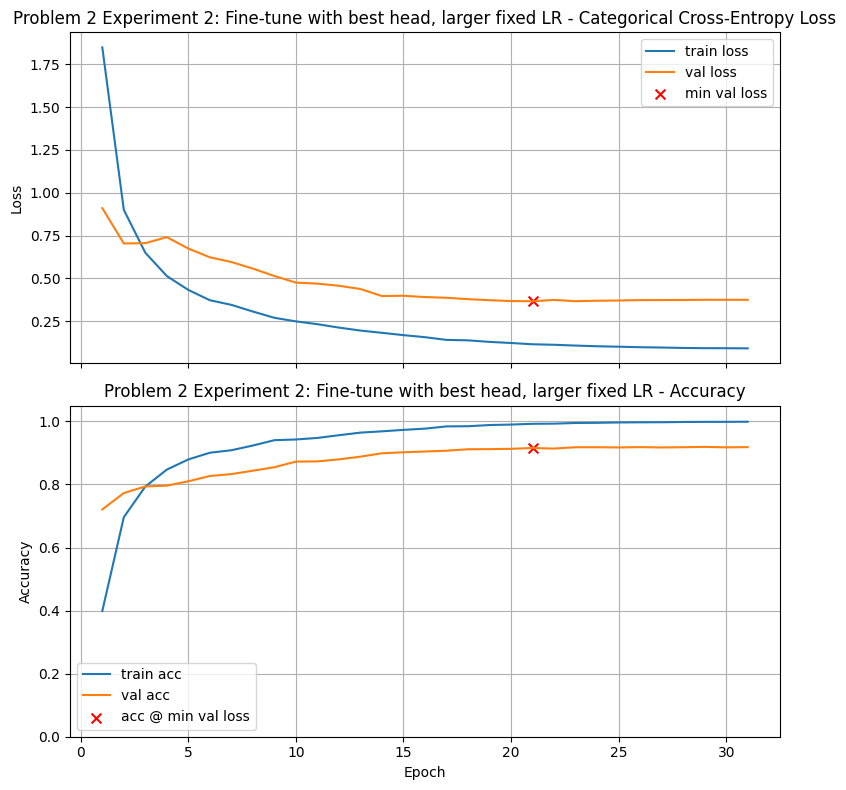

Final Training Loss:            0.0914
Final Training Accuracy:        0.9989
Final Validation Loss:          0.3749
Final Validation Accuracy:      0.9184
Validation Accuracy @ Min Loss: 0.9156

Test Loss: 0.3679
Test Accuracy: 0.9173

Validation-Test Gap (accuracy): 0.001765

Execution Time: 00:05:47


In [17]:
# Problem 2 Experiment 2: Fine-tuning with the best head from Problem 1 and Cosine Decay

# Build the unfrozen MobileNetV2 base model
base_model_prob2_exp2 = make_base_model_pooled(trainable=True)

# Combine the unfrozen base model with the best head from Problem 1
model_prob2_exp2 = models.Sequential([
    base_model_prob2_exp2,
    Dense(256, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax') # Use the output shape of the base model
])

# Fine-tune with Cosine Decay learning rate
train_and_test(model_prob2_exp2, title="Problem 2 Experiment 2: Fine-tune with best head, larger fixed LR", epochs=50, patience=10, lr_schedule=3e-5, callbacks=[reduce_lr])

### Problem 2 Experiment 3: Fine-tuning with the best head from Problem 1 and Exponential Decay

This experiment uses the best head from Problem 1 and fine-tunes the unfrozen backbone with an Exponential Decay learning rate schedule.


Problem 2 Experiment 3: Fine-tune with best head, Exponential Decay LR



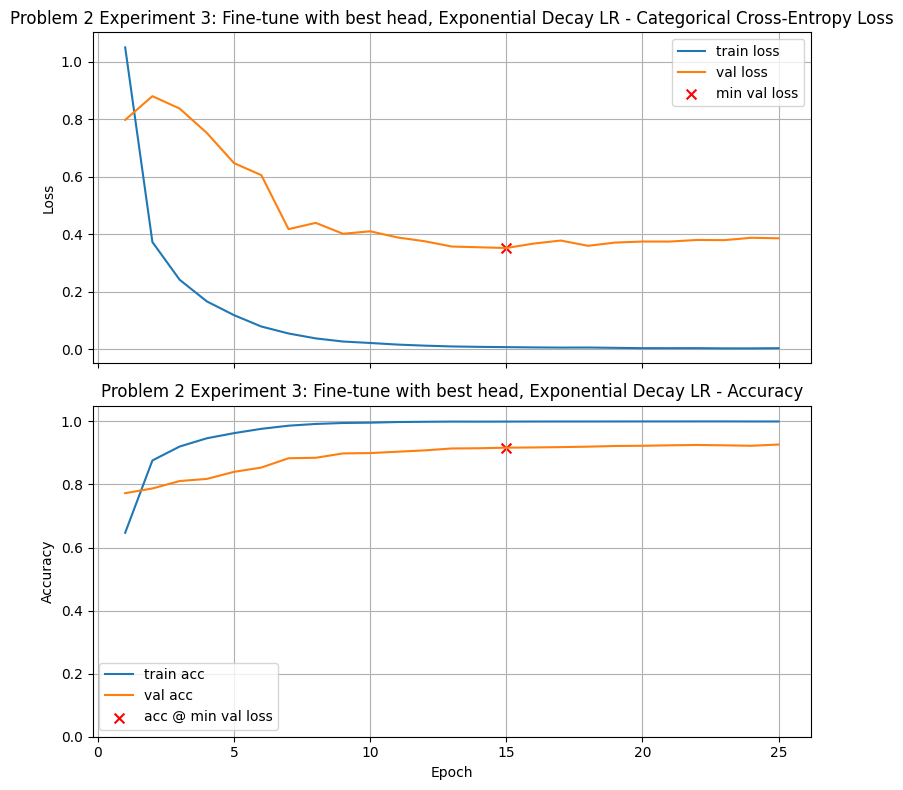

Final Training Loss:            0.0034
Final Training Accuracy:        0.9997
Final Validation Loss:          0.3856
Final Validation Accuracy:      0.9266
Validation Accuracy @ Min Loss: 0.9166

Test Loss: 0.3459
Test Accuracy: 0.9160

Validation-Test Gap (accuracy): 0.000637

Execution Time: 00:04:54


In [18]:
# Problem 2 Experiment 3: Fine-tuning with the best head from Problem 1 and Exponential Decay

# Build the unfrozen MobileNetV2 base model
base_model_prob2_exp3 = make_base_model_pooled(trainable=True)

# Combine the unfrozen base model with the best head from Problem 1
model_prob2_exp3 = models.Sequential([
    base_model_prob2_exp3,
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax') # Use the output shape of the base model
])

# Fine-tune with Exponential Decay learning rate
train_and_test(model_prob2_exp3, title="Problem 2 Experiment 3: Fine-tune with best head, Exponential Decay LR", epochs=50, patience=10, lr_schedule=exp_decay)

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your answer here:**





The 2nd set of experiments took the head from the first problem set as the new baseline. From there, the pretrained model was unfroze to allow additional training. The three experiments consisted of updates to the head and changes to the training and testing process. Of the 3 experiments run, the best was the final which removed L2 regularization from the head and added exponential decay to the training and testing of the model. The exponential learning rate most likely was the most influential factor as it allowed the model to make incremental updates as the learning rate got smaller.

In [24]:
# Set a2 to the validation accuracy found by your best model for this problem.

a2 = 0.9166             # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem

print(f'a2 = {a2:.4f}')

a2 = 0.9166


## Problem Three: Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$** layers to fine-tune. (In Problem 4 you’ll try unfreezing the top **K blocks** instead.)

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model unfreeze the top $N$ layers using the following approach:

    N=20
    model = make_base_model_pooled()
    base_model.trainable = True
    for layer in base_model.layers[:-N]:
        layer.trainable = False

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen.** Vary hyperparameters such as:
   * $N\in \{20,40,60, 80\}$
   * **Head choice** (pick one from Problem 1).
   * **Learning rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay** (your choice of settings).
   * **Early Stopping** settings.
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (you can combine it with a fixed LR).
2. **Run and compare** the three experimentsand **give each experiment a unique descriptive title,** i.e., `title="Problem 3 Experiment 1"`
3. **Answer the graded questions**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


Problem 3 Experiment 1: Fine-tune with best head, Exponential Decay L, with last 20 rows unfrozen



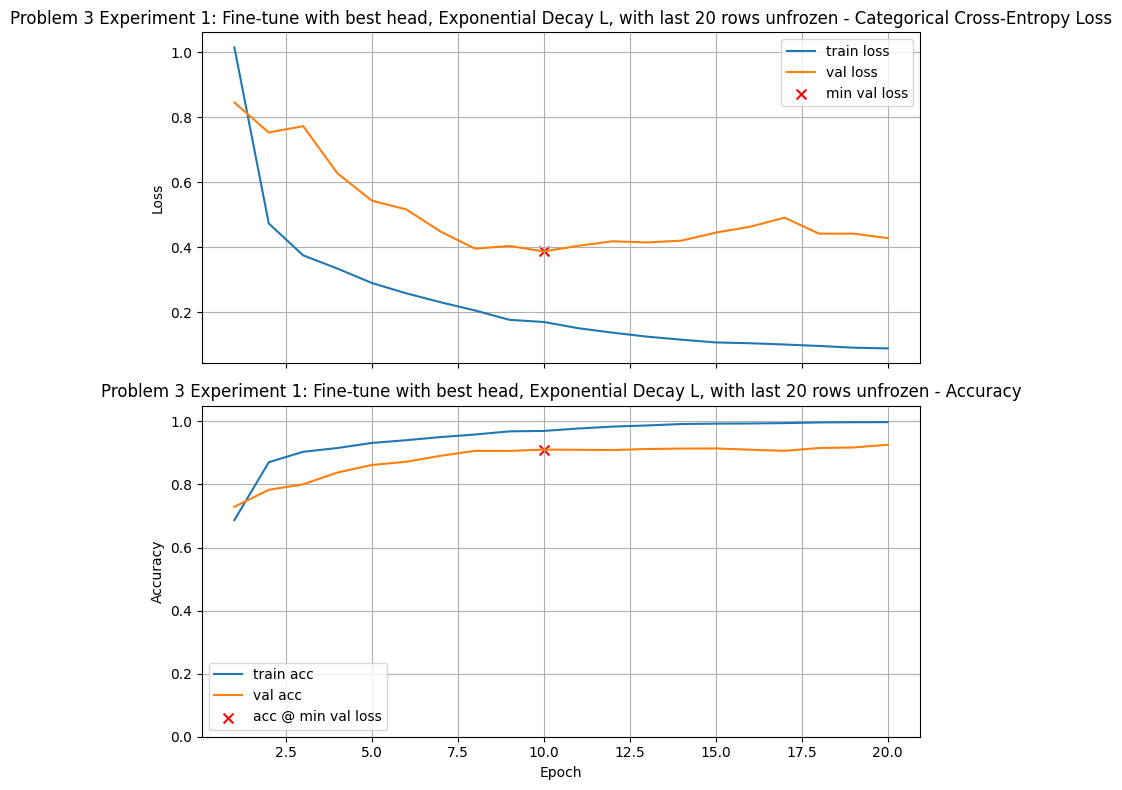

Final Training Loss:            0.0891
Final Training Accuracy:        0.9977
Final Validation Loss:          0.4282
Final Validation Accuracy:      0.9259
Validation Accuracy @ Min Loss: 0.9106

Test Loss: 0.3986
Test Accuracy: 0.9073

Validation-Test Gap (accuracy): 0.003247

Execution Time: 00:02:18

Problem 3 Experiment 2: Fine-tune with best head, Exponential Decay L, with last 40 rows unfrozen



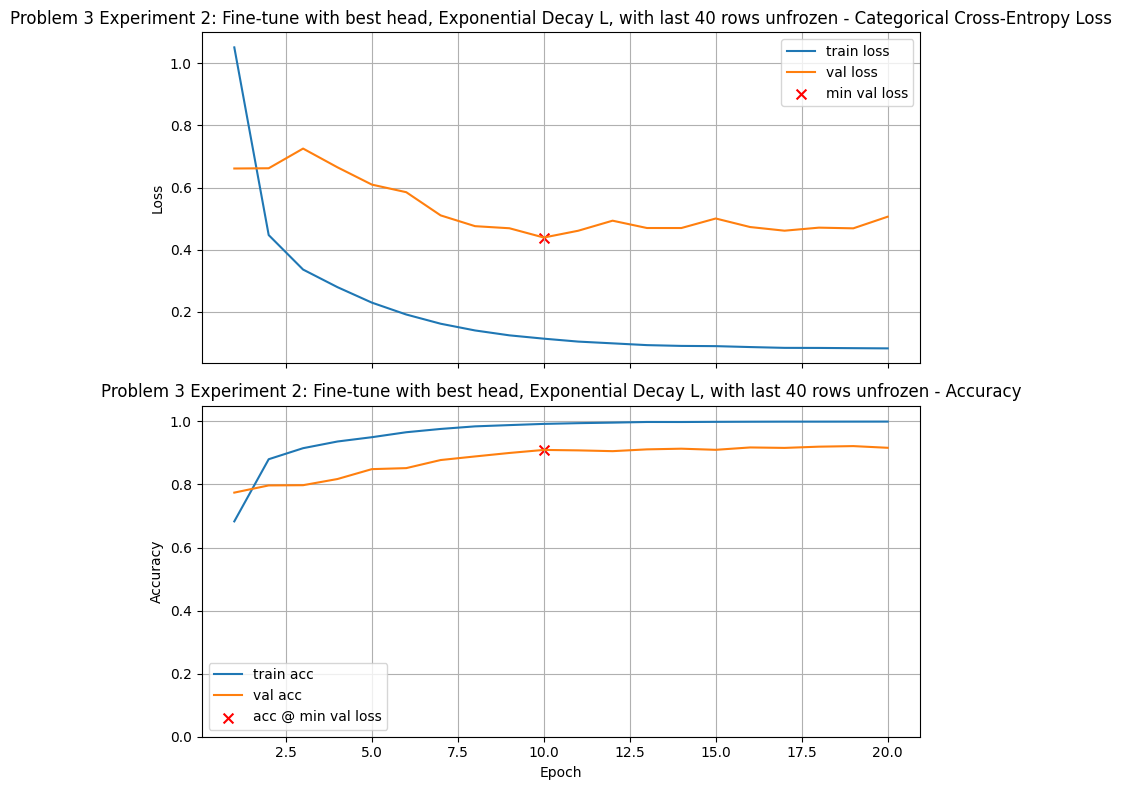

Final Training Loss:            0.0813
Final Training Accuracy:        0.9994
Final Validation Loss:          0.5059
Final Validation Accuracy:      0.9163
Validation Accuracy @ Min Loss: 0.9095

Test Loss: 0.4145
Test Accuracy: 0.9113

Validation-Test Gap (accuracy): 0.001821

Execution Time: 00:02:29

Problem 3 Experiment 3: Fine-tune with best head, Exponential Decay L, with last 60 rows unfrozen



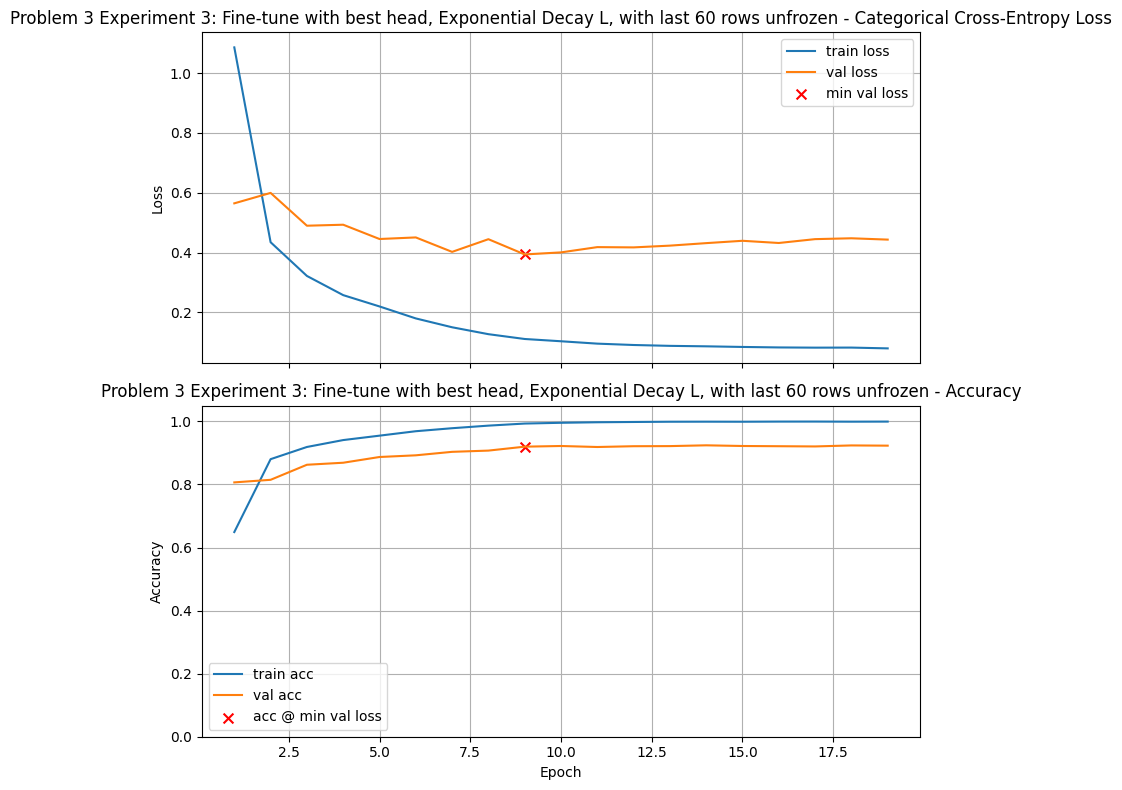

Final Training Loss:            0.0798
Final Training Accuracy:        0.9994
Final Validation Loss:          0.4435
Final Validation Accuracy:      0.9230
Validation Accuracy @ Min Loss: 0.9198

Test Loss: 0.3779
Test Accuracy: 0.9203

Validation-Test Gap (accuracy): 0.000490

Execution Time: 00:02:38


In [21]:
# Build the MobileNetV2 base model with the last N layers unfozen
N=[20,40,60]

for i, n in enumerate(N):
  base_model_prob3 = make_base_model_pooled()
  base_model_prob3.trainable = True
  for layer in base_model_prob3.layers[:-n]:
      layer.trainable = False

  # Combine the unfrozen base model with the best head from Problem 1
  model_prob3 = models.Sequential([
      base_model_prob3,
      Dense(256, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
      BatchNormalization(),
      Dropout(0.5),
      Dense(128, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
      BatchNormalization(),
      Dropout(0.4),
      Dense(num_classes, activation='softmax') # Use the output shape of the base model
  ])

  # Fine-tune with Exponential Decay learning rate
  train_and_test(model_prob3, title=f"Problem 3 Experiment {i+1}: Fine-tune with best head, Exponential Decay L, with last {n} rows unfrozen", epochs=50, patience=10, lr_schedule=exp_decay)

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your answer here:**




Each of the three experiments run used the same head and train/test parameters. What changed was the number of layers unfrozen during training. An additional 20 were added for each successive experiment. The final experiment performed the best during validation. This boost in validation performance can be attributed to the additional layers which allows the model to finetun a larger portion of the pre-trained backbone. The Exponential Decay learning rate also contributed to the performance.

In [26]:
# Set a3 to the validation accuracy found by your best model for this problem.

a3 = 0.9198             # Replace 0.0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3 = {a3:.4f}')

a3 = 0.9198


## Problem Four: Unfreezing Convolution Blocks

After creating a model, unfreeze the top $K$ conv block using the following approach:

    block_prefixes = [
        'block_1', 'block_2', 'block_3', 'block_4',
        'block_5', 'block_6', 'block_7', 'block_8',
        'block_9', 'block_10', 'block_11', 'block_12',
        'block_13', 'block_14', 'block_15', 'block_16',
        'Conv_1',   # final 1×1 conv stage before pooling
    ]
    
    K = 3
        
    model = make_base_model_pooled(trainable=False)
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):           # Optional:  Often recommended to keep BN layers frozen
            layer.trainable = False                                         # Optional
        else:                                                               # Optiomal
            layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])




### To Do:

1. **Design at least three experiments** with the model having the **last K stages unfrozen**. Vary:

   * $K \in \{1,2,3,4,5\}$  *(K counts stages/blocks, not individual layers)*
   * **Unfreeze Batch Normalization** Layers or keep them frozen (see "Optional" in above code)
   * **Head choice** (pick one from Problem 1)
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** parameters
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 4 Experiment 1"`
3. **Answer the graded questions.**

**Notes**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


Problem 4 Experiment 1: Fine-tune with best head, Exponential Decay LR, with last 2 blocks unfrozen



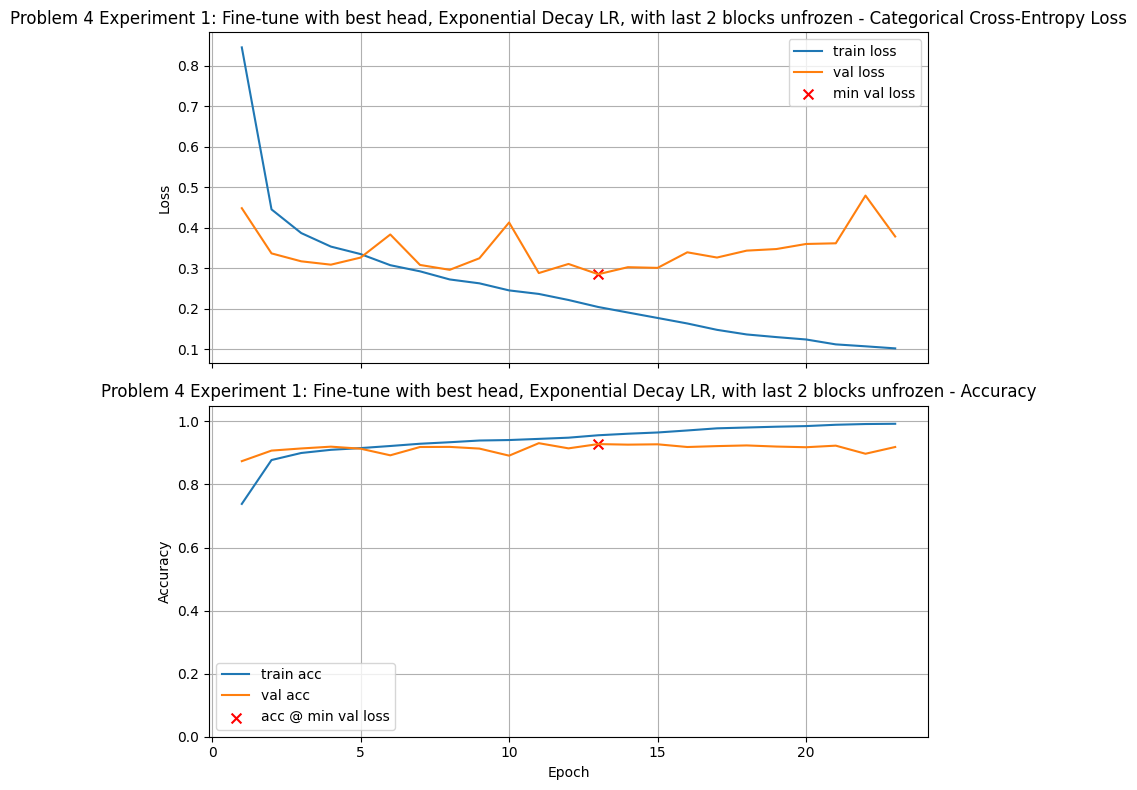

Final Training Loss:            0.1019
Final Training Accuracy:        0.9924
Final Validation Loss:          0.3781
Final Validation Accuracy:      0.9188
Validation Accuracy @ Min Loss: 0.9280

Test Loss: 0.2931
Test Accuracy: 0.9283

Validation-Test Gap (accuracy): 0.000296

Execution Time: 00:02:25

Problem 4 Experiment 2: Fine-tune with best head, Exponential Decay LR, with last 4 blocks unfrozen



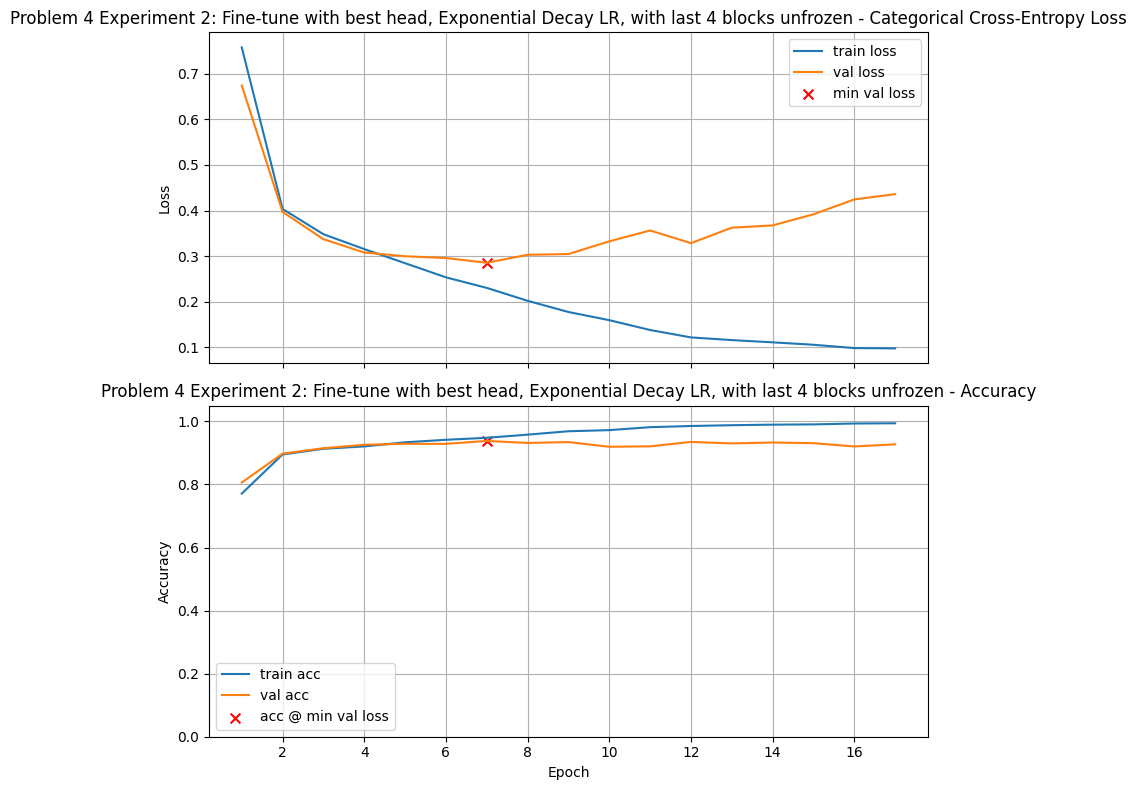

Final Training Loss:            0.0979
Final Training Accuracy:        0.9940
Final Validation Loss:          0.4359
Final Validation Accuracy:      0.9273
Validation Accuracy @ Min Loss: 0.9380

Test Loss: 0.2864
Test Accuracy: 0.9330

Validation-Test Gap (accuracy): 0.005012

Execution Time: 00:02:02

Problem 4 Experiment 3: Fine-tune with best head, Exponential Decay LR, with last 6 blocks unfrozen



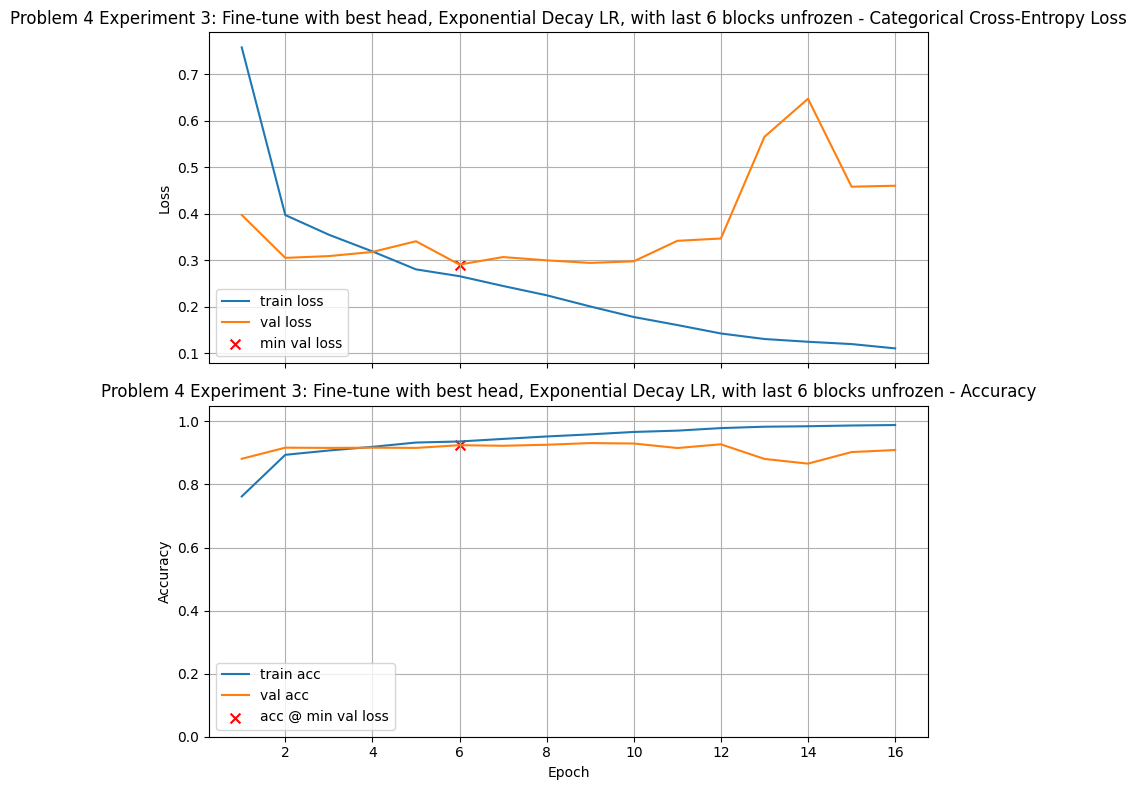

Final Training Loss:            0.1100
Final Training Accuracy:        0.9884
Final Validation Loss:          0.4601
Final Validation Accuracy:      0.9092
Validation Accuracy @ Min Loss: 0.9245

Test Loss: 0.2978
Test Accuracy: 0.9200

Validation-Test Gap (accuracy): 0.004475

Execution Time: 00:02:02


In [31]:
# Build the MobileNetV2 base model with the last N layers unfozen
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',   # final 1×1 conv stage before pooling
]

K = [2,4,6]

for i, n in enumerate(K):

  base_model_prob4 = make_base_model_pooled(trainable=False)

  for layer in base_model_prob4.layers:
      if isinstance(layer, tf.keras.layers.BatchNormalization):           # Optional:  Often recommended to keep BN layers frozen
          layer.trainable = False                                         # Optional
      else:                                                               # Optiomal
          layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-n:])

  # Combine the unfrozen base model with the best head from Problem 1
  model_prob4 = models.Sequential([
      base_model_prob4,
      Dense(256, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
      BatchNormalization(),
      Dropout(0.5),
      Dense(128, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
      BatchNormalization(),
      Dropout(0.4),
      Dense(num_classes, activation='softmax') # Use the output shape of the base model
  ])

  # Fine-tune with Exponential Decay learning rate
  train_and_test(model_prob4, title=f"Problem 4 Experiment {i+1}: Fine-tune with best head, Exponential Decay LR, with last {n} blocks unfrozen", epochs=50, patience=10, lr_schedule=exp_decay)


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks.

**Your answer here:**




Problem 4 Experiment 1 (last 2 blocks unfrozen) achieved a validation accuracy of 0.9280. Problem 4 Experiment 2 (last 4 blocks unfrozen) achieved a validation accuracy of 0.9380. Problem 4 Experiment 3 (last 6 blocks unfrozen) achieved a validation accuracy of 0.9245.

In Problem 4, Experiment 2, where the last 4 convolutional blocks were unfrozen, yielded the highest validation accuracy of 0.9380. This suggests that unfreezing an intermediate number of blocks was most effective for this dataset and model architecture. Unfreezing too few layers might not provide enough flexibility to adapt to the new data, while unfreezing too many could lead to overfitting or disrupt the learned features from the pre-trained model. The Exponential Decay learning rate schedule likely also played a role in these results.

In [32]:
# Set a4 to the validation accuracy found by your best model for this problem.

a4 = 0.9380             # Replace 0.0 with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4 = {a4:.4f}')

a4 = 0.9380


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework.

This reflection question is worth 5 points.

In [34]:
# Print out summary of validation accuracy for each experiment

print_results()

Problem 4 Experiment 2: Fine-tune with best head, Exponential Decay LR, with last 4 blocks unfrozen	0.9380	7
Problem 4 Experiment 1: Fine-tune with best head, Exponential Decay LR, with last 2 blocks unfrozen	0.9280	13
Problem 4 Experiment 3: Fine-tune with best head, Exponential Decay LR, with last 6 blocks unfrozen	0.9245	6
Problem 3 Experiment 3: Fine-tune with best head, Exponential Decay L, with last 60 rows unfrozen	0.9198	9
Problem 1 Experiment 2: Multi Dense Layer with ReLU, L2 Reg, and Batch Norm & Dropout	0.9177	6
Problem 2 Experiment 3: Fine-tune with best head, Exponential Decay LR	0.9166	15
Problem 2 Experiment 2: Fine-tune with best head, larger fixed LR	0.9156	21
Model Baseline                          	0.9124	9
Problem 1 Experiment 1: Single Dense Layer with Batch Norm and Dropout	0.9106	7
Problem 3 Experiment 1: Fine-tune with best head, Exponential Decay L, with last 20 rows unfrozen	0.9106	10
Problem 3 Experiment 2: Fine-tune with best head, Exponential Decay L, with

### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your answer here:**




Observing the results, the freezing and unfreezing of layers/blocks of the model were the most effective methods. Those solutions allowed the model the keep its knowledge of learned feature relationships while balancing explorability and adaptability of new ones. Unfreezing blocks yielded the greatest results. One parameter that seemed more effective than others was the learning rate scheduling. Closer to the back half of this assignment, I decided to use exponential decay as the learning rate, this improved validation performance as the models got larger.

## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

![Screenshot 2025-09-25 at 3.38.21 PM.png](attachment:2f17cb78-416f-4995-9eec-8b50c70dabf8.png)


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### TL;DR Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
